In [1]:
# Step 1: Import All Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some display options for better viewing
pd.set_option('display.max_columns', 10)
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('C:/Users/HP/OneDrive/Desktop/22070521124_Sakshi_Bhoyar/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv')
print("Dataset loaded successfully!")
print(f"Original dataset shape: {df.shape}")

Dataset loaded successfully!
Original dataset shape: (101766, 50)


In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,...,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),...,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),...,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),...,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),...,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),...,No,No,Ch,Yes,NO


In [4]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [5]:
# 'weight', 'payer_code', 'medical_specialty' have too many missing values to be useful.
# 'encounter_id', 'patient_nbr' are identifiers.
# 'citoglipton', 'examide' contain only one value ('No') and have no predictive power.
# 'diag_2', 'diag_3' are dropped to focus on the primary diagnosis.
cols_to_drop = [
    'weight', 'payer_code', 'medical_specialty', # High nulls
    'encounter_id', 'patient_nbr',              # Irrelevant IDs
    'citoglipton', 'examide',                   # No variance
    'diag_2', 'diag_3'                          # Redundant diagnoses
]
df.drop(columns=cols_to_drop, inplace=True)

In [6]:
print(f"Shape after dropping non-essential columns: {df.shape}")

Shape after dropping non-essential columns: (101766, 41)


In [7]:
# The 'gender' column has a value 'Unknown/Invalid'. This is a data quality issue.
# We will remove these 3 specific rows.
df = df[df['gender'] != 'Unknown/Invalid']

In [8]:
# Impute missing 'race' with the mode (most frequent value)
df['race'].fillna(df['race'].mode()[0], inplace=True)

# Impute missing 'diag_1' with the mode
df['diag_1'].fillna(df['diag_1'].mode()[0], inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_20376\1666541101.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['race'].fillna(df['race'].mode()[0], inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_20376\1666541101.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [9]:
# For lab tests, 'NaN' means the test wasn't performed. We'll label it as such.
df['max_glu_serum'].fillna('Not Measured', inplace=True)
df['A1Cresult'].fillna('Not Measured', inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_20376\964244973.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['max_glu_serum'].fillna('Not Measured', inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_20376\964244973.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [10]:
print("\nTotal missing values left:", df.isnull().sum().sum())


Total missing values left: 0


In [11]:
# This helps in analyzing what factors lead to early readmission.
# '<30' becomes 1, while '>30' and 'NO' become 0.
df['readmitted_binary'] = df['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})

C:\Users\HP\AppData\Local\Temp\ipykernel_20376\23518019.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['readmitted_binary'] = df['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})


In [12]:
# 4.2. Engineering the 'age' feature
# Convert the age range into a numeric value for easier plotting.
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
    '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}
df['age_numeric'] = df['age'].map(age_mapping)

print("\nDataset is now clean and ready for EDA.")
print("Final shape:", df.shape)
print("\nData types:")
df.info()

print("\nPreview of the data prepared for EDA:")
df.head()


Dataset is now clean and ready for EDA.
Final shape: (101763, 43)

Data types:
<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101765
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101763 non-null  object
 1   gender                    101763 non-null  object
 2   age                       101763 non-null  object
 3   admission_type_id         101763 non-null  int64 
 4   discharge_disposition_id  101763 non-null  int64 
 5   admission_source_id       101763 non-null  int64 
 6   time_in_hospital          101763 non-null  int64 
 7   num_lab_procedures        101763 non-null  int64 
 8   num_procedures            101763 non-null  int64 
 9   num_medications           101763 non-null  int64 
 10  number_outpatient         101763 non-null  int64 
 11  number_emergency          101763 non-null  int64 
 12  number_inpatient          101763 non-nu

,race,gender,age,admission_type_id,discharge_disposition_id,...,change,diabetesMed,readmitted,readmitted_binary,age_numeric
0,Caucasian,Female,[0-10),6,25,...,No,No,NO,0,5
1,Caucasian,Female,[10-20),1,1,...,Ch,Yes,>30,0,15
2,AfricanAmerican,Female,[20-30),1,1,...,No,Yes,NO,0,25
3,Caucasian,Male,[30-40),1,1,...,Ch,Yes,NO,0,35
4,Caucasian,Male,[40-50),1,1,...,Ch,Yes,NO,0,45


In [13]:
# For numerical columns
print("--- Descriptive Statistics for Numerical Features ---")
print(df.describe())

# For categorical columns
print("\n--- Descriptive Statistics for Categorical Features ---")
print(df.describe(include=['object']))

--- Descriptive Statistics for Numerical Features ---
       admission_type_id  discharge_disposition_id  admission_source_id  \
count      101763.000000             101763.000000        101763.000000   
mean            2.024017                  3.715515             5.754459   
std             1.445414                  5.279919             4.064110   
min             1.000000                  1.000000             1.000000   
25%             1.000000                  1.000000             1.000000   
50%             1.000000                  1.000000             7.000000   
75%             3.000000                  4.000000             7.000000   
max             8.000000                 28.000000            25.000000   

       time_in_hospital  num_lab_procedures  ...  number_emergency  \
count     101763.000000       101763.000000  ...     101763.000000   
mean           4.396018           43.095909  ...          0.197842   
std            2.985092           19.674220  ...          0.

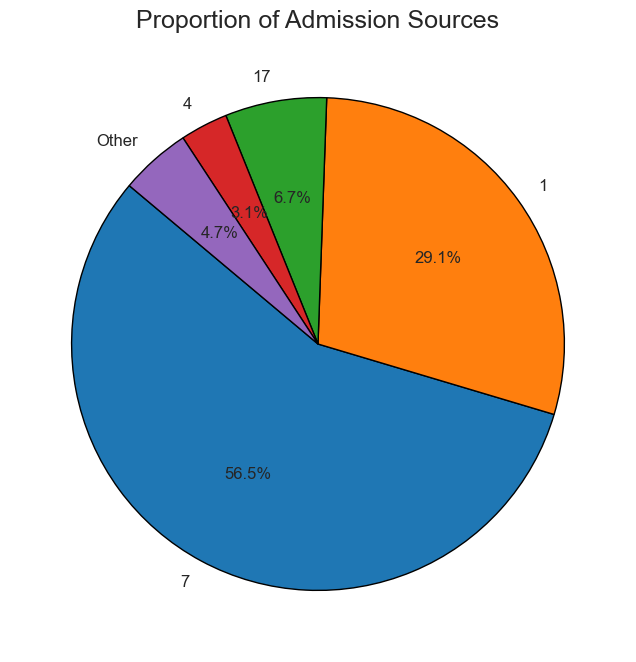

In [14]:
# We'll group the smaller categories into 'Other' to make the pie chart cleaner.
admission_counts = df['admission_source_id'].value_counts()
top_sources = admission_counts.nlargest(4)
other_count = admission_counts.nsmallest(len(admission_counts) - 4).sum()
top_sources['Other'] = other_count

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_sources, labels=top_sources.index, autopct='%1.1f%%', startangle=140,
        wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12})
plt.title('Proportion of Admission Sources', fontsize=18)
plt.ylabel('') # Hides the 'None' label on the y-axis
plt.show()

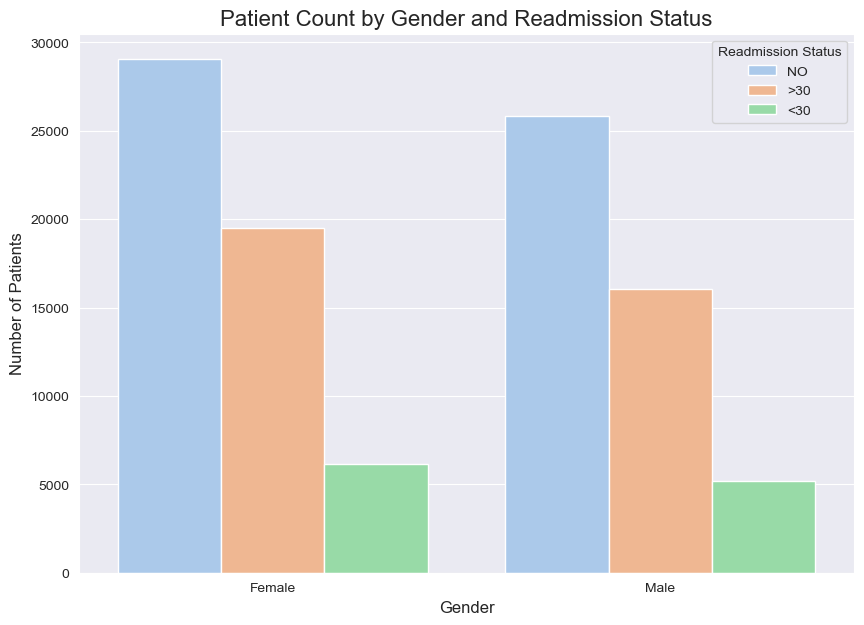

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.countplot(x='gender', hue='readmitted', data=df, palette='pastel')
plt.title('Patient Count by Gender and Readmission Status', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.legend(title='Readmission Status')
plt.show()

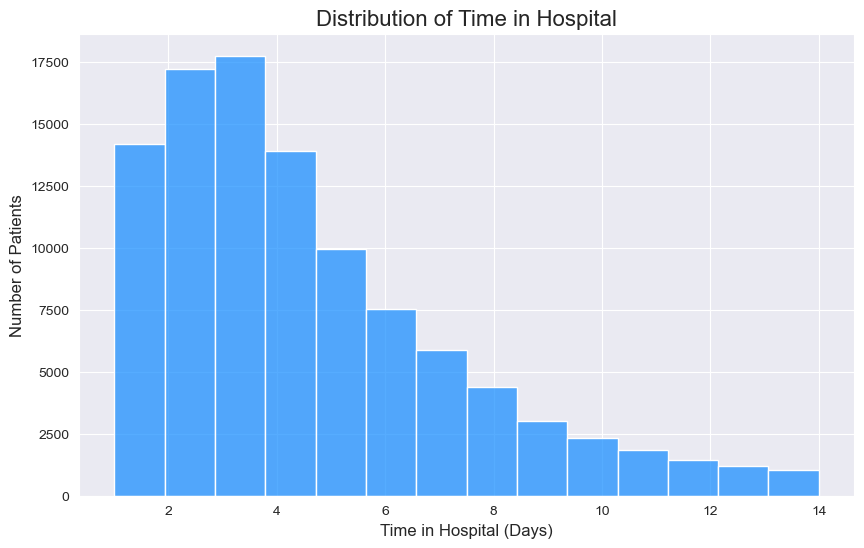

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df['time_in_hospital'], bins=14, kde=False, color='dodgerblue')
plt.title('Distribution of Time in Hospital', fontsize=16)
plt.xlabel('Time in Hospital (Days)', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.show()

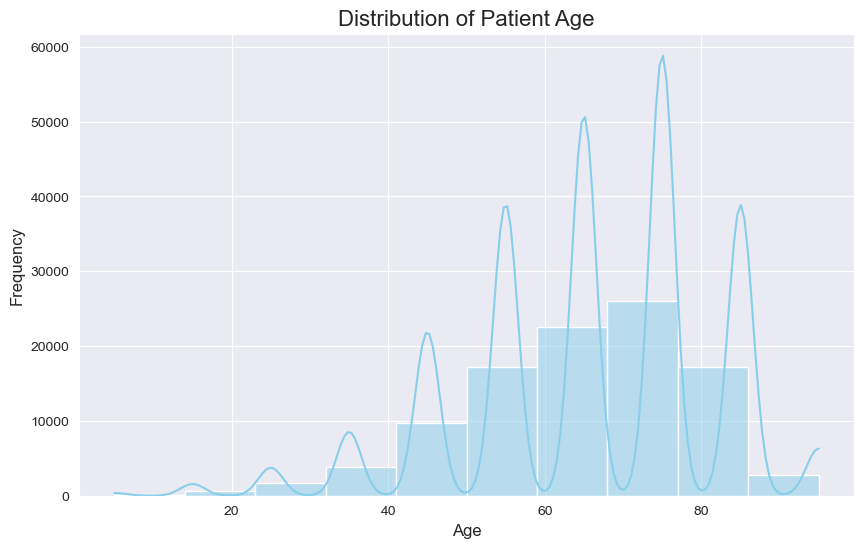

In [17]:
# 5.3. Distribution of Patient Age
plt.figure(figsize=(10, 6))
sns.histplot(df['age_numeric'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Patient Age', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_20376\2781894051.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='readmitted', data=df, palette='viridis', order=['NO', '>30', '<30'])


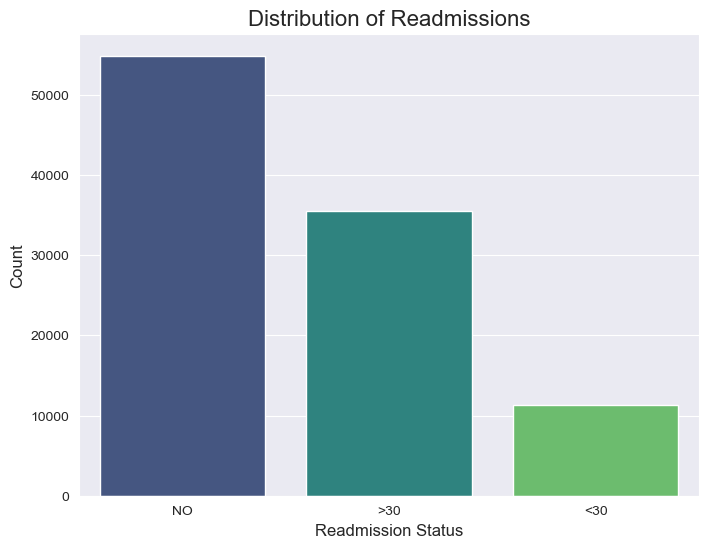

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='readmitted', data=df, palette='viridis', order=['NO', '>30', '<30'])
plt.title('Distribution of Readmissions', fontsize=16)
plt.xlabel('Readmission Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

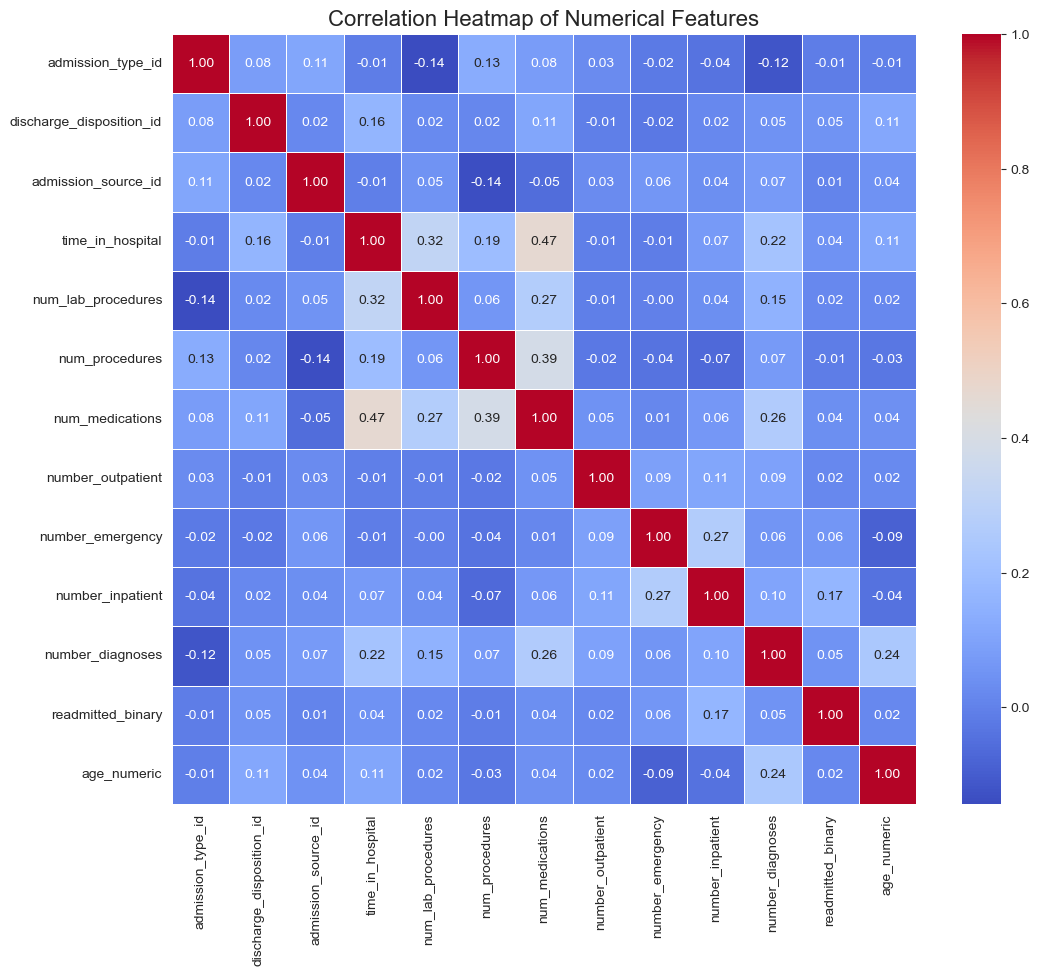

In [19]:
numerical_cols = df.select_dtypes(include=np.number)

# Next, calculate the correlation matrix
correlation_matrix = numerical_cols.corr()

# Now, create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

In [20]:
# Save the preprocessed DataFrame to a new CSV file
df.to_csv('diabetes_preprocessed_for_eda.csv', index=False)

print("\nPreprocessed data has been successfully saved to 'diabetes_preprocessed_for_eda.csv'")


Preprocessed data has been successfully saved to 'diabetes_preprocessed_for_eda.csv'


In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# Select important columns based on EDA
selected_columns = [
    'race', 'gender', 'age_numeric', 'time_in_hospital',
    'num_lab_procedures', 'num_medications', 'number_diagnoses',
    'change', 'diabetesMed', 'readmitted_binary'
]
df = df[selected_columns].copy()

In [22]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
for col in ['race', 'gender', 'change', 'diabetesMed']:
    df[col] = label_enc.fit_transform(df[col].astype(str))

# Convert everything to numeric (safety)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

In [23]:
from sklearn.model_selection import train_test_split

X = df.drop('readmitted_binary', axis=1)
y = df['readmitted_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

log_model = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("🔹 Logistic Regression 🔹")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

🔹 Logistic Regression 🔹
[[9117 8965]
 [ 910 1361]]
              precision    recall  f1-score   support

           0       0.91      0.50      0.65     18082
           1       0.13      0.60      0.22      2271

    accuracy                           0.51     20353
   macro avg       0.52      0.55      0.43     20353
weighted avg       0.82      0.51      0.60     20353



In [26]:
from sklearn.tree import DecisionTreeClassifier

# Train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate
print("🔹 Decision Tree Classifier 🔹")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


🔹 Decision Tree Classifier 🔹
[[15861  2221]
 [ 1960   311]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     18082
           1       0.12      0.14      0.13      2271

    accuracy                           0.79     20353
   macro avg       0.51      0.51      0.51     20353
weighted avg       0.80      0.79      0.80     20353



In [27]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("🔹 Random Forest Classifier 🔹")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


🔹 Random Forest Classifier 🔹
[[17850   232]
 [ 2229    42]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     18082
           1       0.15      0.02      0.03      2271

    accuracy                           0.88     20353
   macro avg       0.52      0.50      0.48     20353
weighted avg       0.81      0.88      0.83     20353



In [28]:
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Predict on test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate
print("🔹 K-Nearest Neighbors (KNN) 🔹")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


🔹 K-Nearest Neighbors (KNN) 🔹
[[17385   697]
 [ 2167   104]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     18082
           1       0.13      0.05      0.07      2271

    accuracy                           0.86     20353
   macro avg       0.51      0.50      0.50     20353
weighted avg       0.80      0.86      0.83     20353



In [29]:
import warnings
warnings.filterwarnings('ignore')


In [30]:
from xgboost import XGBClassifier

# Train the XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, scale_pos_weight=3)
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("🔹 XGBoost Classifier 🔹")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

🔹 XGBoost Classifier 🔹
[[17951   131]
 [ 2240    31]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     18082
           1       0.19      0.01      0.03      2271

    accuracy                           0.88     20353
   macro avg       0.54      0.50      0.48     20353
weighted avg       0.81      0.88      0.84     20353



In [31]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("🔹 Gradient Boosting Classifier 🔹")
print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))


🔹 Gradient Boosting Classifier 🔹
[[18080     2]
 [ 2271     0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18082
           1       0.00      0.00      0.00      2271

    accuracy                           0.89     20353
   macro avg       0.44      0.50      0.47     20353
weighted avg       0.79      0.89      0.84     20353



In [33]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

results = []

models = {
    'Logistic Regression': (y_pred_log, log_model),
    'Decision Tree': (y_pred_dt, dt_model),
    'Random Forest': (y_pred_rf, rf_model),
    'KNN': (y_pred_knn, knn_model),
    'Gradient Boosting': (y_pred_gb, gb_model),
    'XGBoost': (y_pred_xgb, xgb_model)
}

for name, (y_pred, model) in models.items():
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        'Model': name,
        'Accuracy': round(accuracy_score(y_test, y_pred), 3),
        'Precision': round(report['weighted avg']['precision'], 3),
        'Recall': round(report['weighted avg']['recall'], 3),
        'F1-Score': round(report['weighted avg']['f1-score'], 3)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)
display(results_df)


,Model,Accuracy,Precision,Recall,F1-Score
4,Gradient Boosting,0.888,0.789,0.888,0.836
5,XGBoost,0.884,0.811,0.884,0.836
2,Random Forest,0.879,0.807,0.879,0.835
3,KNN,0.859,0.804,0.859,0.828
1,Decision Tree,0.795,0.804,0.795,0.799
0,Logistic Regression,0.515,0.822,0.515,0.600


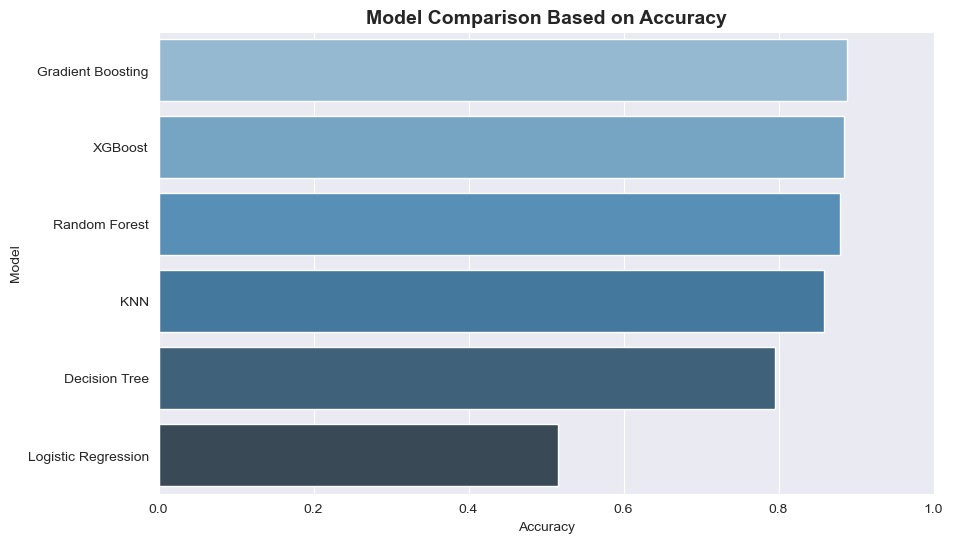

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='Blues_d')
plt.title('Model Comparison Based on Accuracy', fontsize=14, weight='bold')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.show()


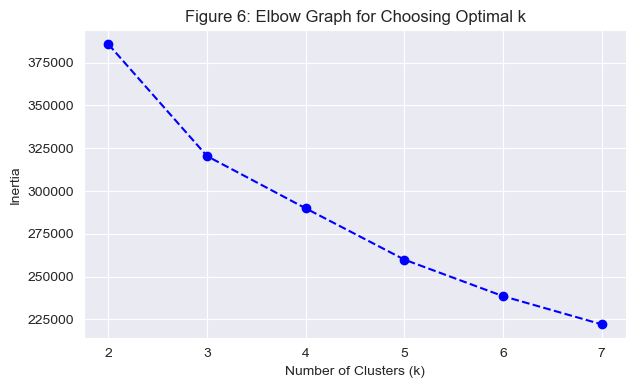

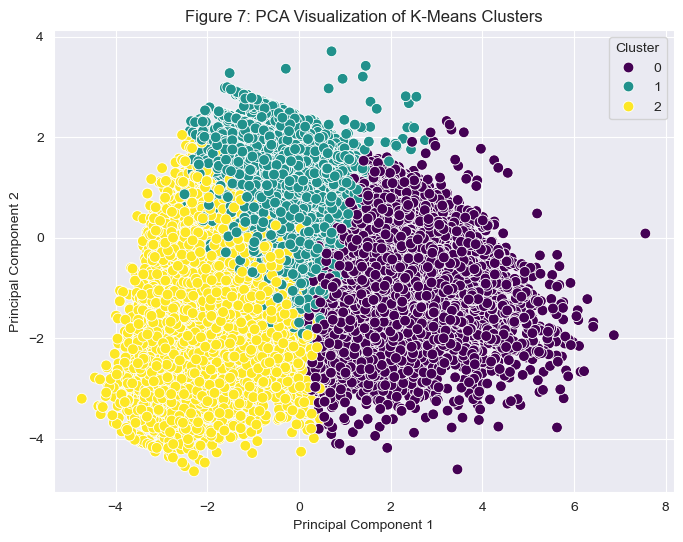

,age_numeric,time_in_hospital,num_lab_procedures,num_medications,number_diagnoses,readmitted_binary
Cluster,,,,,,
0,67.58,8.05,57.50,24.32,8.31,0.13
1,70.52,3.25,38.61,13.97,8.48,0.12
2,57.36,2.96,37.40,11.90,4.97,0.09


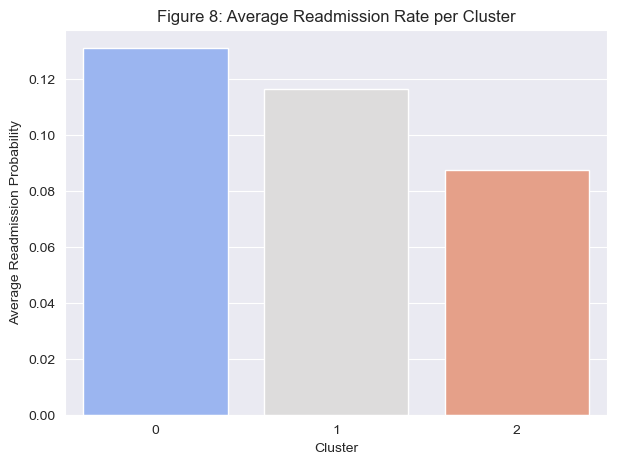

In [37]:
# --- K-Means Clustering (Corrected for your dataset) ---

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Select only numeric continuous features for clustering
features = [
    'age_numeric',
    'time_in_hospital',
    'num_lab_procedures',
    'num_medications',
    'number_diagnoses'
]

X = df[features]

# 2️⃣ Normalize/Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3️⃣ Determine optimal number of clusters (Elbow method)
inertia = []
K_range = range(2, 8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')
plt.title("Figure 6: Elbow Graph for Choosing Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# 4️⃣ Apply K-Means (Assume k=3 after elbow observation)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# 5️⃣ Visualize clusters using PCA (2D)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)
df['PCA1'], df['PCA2'] = pca_data[:, 0], pca_data[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis', s=60)
plt.title("Figure 7: PCA Visualization of K-Means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()

# 6️⃣ Cluster summary statistics
cluster_summary = df.groupby('Cluster')[features + ['readmitted_binary']].mean().round(2)
display(cluster_summary)

# 7️⃣ Visualize average readmission rate per cluster
plt.figure(figsize=(7,5))
sns.barplot(x='Cluster', y='readmitted_binary', data=df, palette='coolwarm', ci=None)
plt.title("Figure 8: Average Readmission Rate per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Readmission Probability")
plt.show()
